# Exercise 4

**Remember**
   * You are expected to use numpy and scipy libraries where appropriate.  
   * You should run each cell in order from the top of the notebook; there is no need to repeat code between cells
   * Use the "refresh kernel" button to reset everything and start again
   * Make sure your notebook runs fully & without errors, from a fresh kernel, before submitting it
   
## Overview

In this exercise, you will simulate an experiment designed to measure the lifetime of an unstable particle X.  A beam of X particles is produced with a known average velocity and injected into a vacuum chamber.  Each X particle will travel some distance into the chamber before decaying at the so-called decay vertex, $r_{vtx}$.  The charged daughter particle is then detected by several tracking stations, located at various distances ($z_{stn}$) along the beam line.  Each tracking station measures the position where the track hits the station, $r_{hit}$.  By extrapolating back from the hit positions, the position of the decay vertex can be reconstructed.  Finally, the distribution of decay points, along with the known average beam velocity, can be used to estimate the mean lifetime of the X particle.

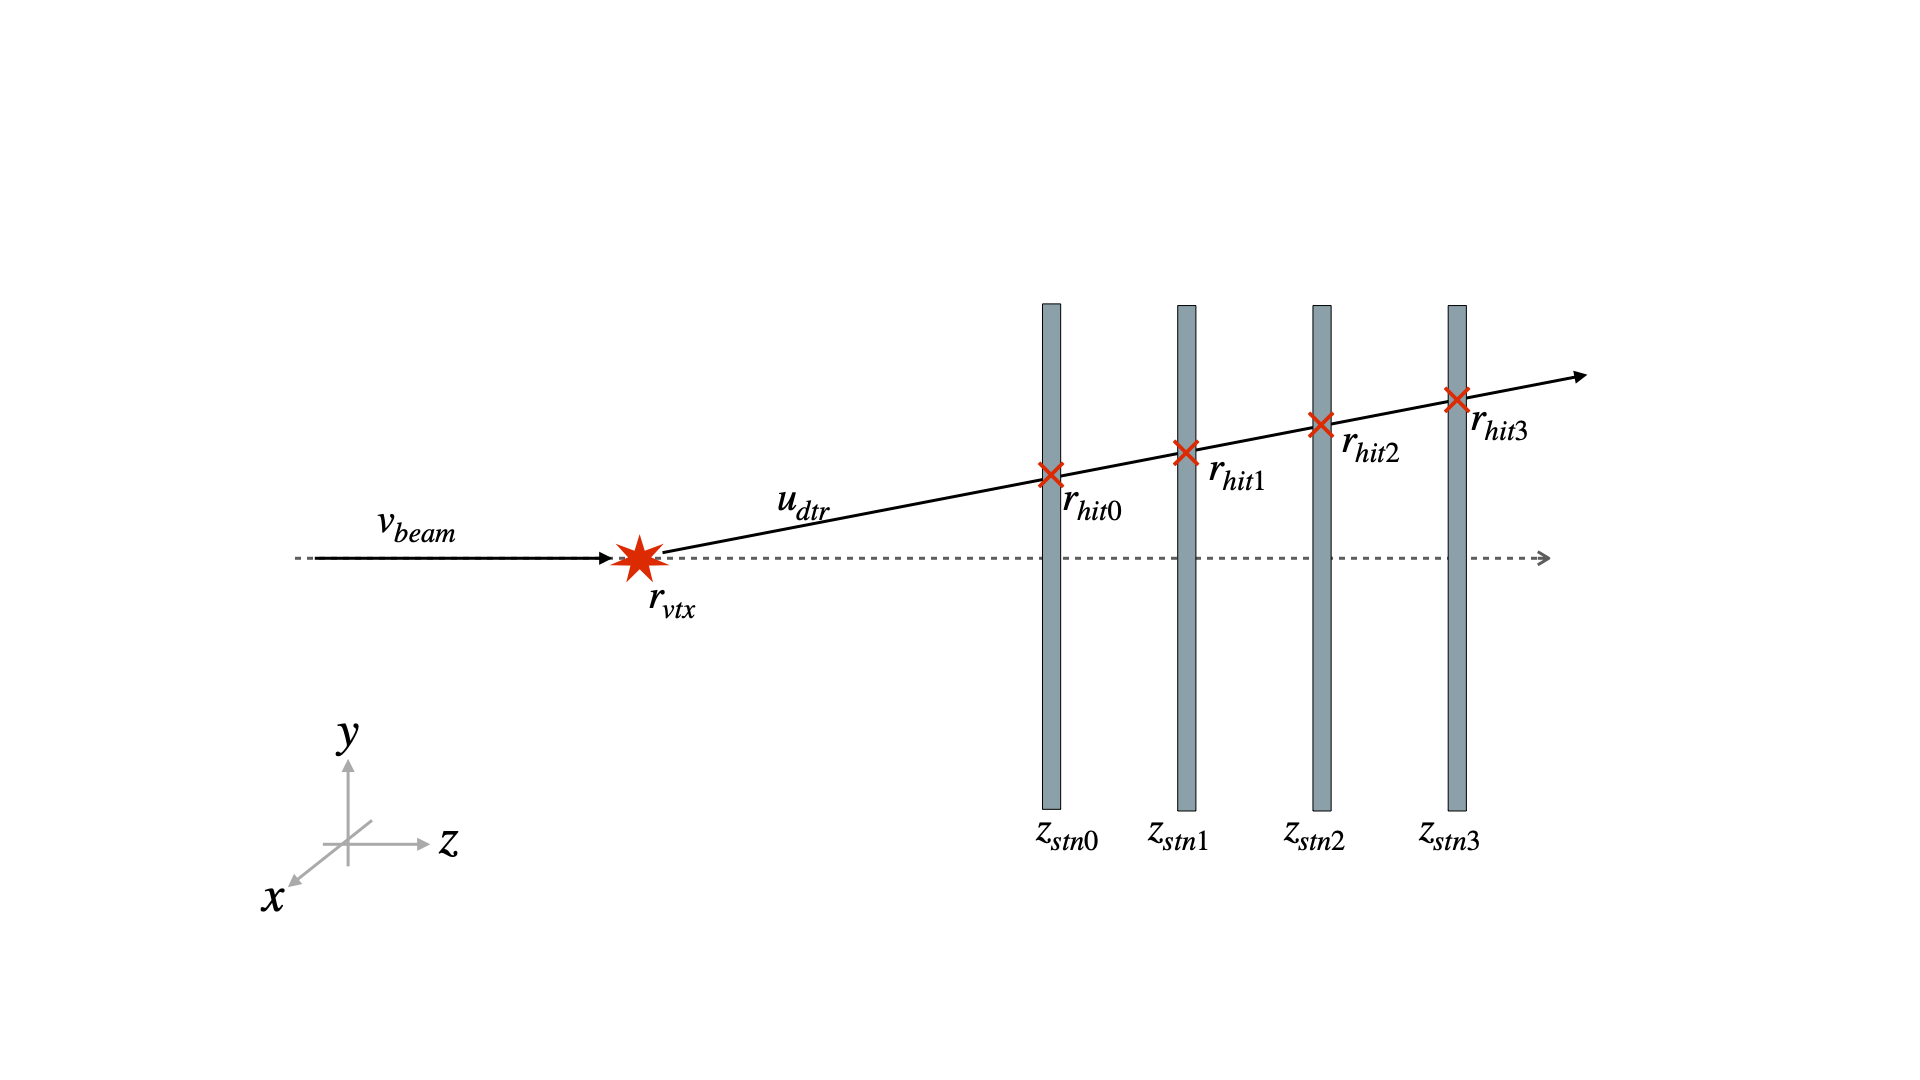

The coordinate system used below is shown in the diagram, where the beam is produced at the origin and travels in the $z$-direction.

You will use Monte Carlo methods to simulate the production, decay, and detection of particle X and it's daughter. Each part of the exercise simulates a different part of the experiment. By building up a set of functions, you will be able to simulate the full experiment.  You will then be able to simulate the experiment under different assumptions (eg. X mass, lifetime, beam parameters, tracking station positions, etc.) and make quantitative statements about how these assumptions influence the performance of the experiment.  It is strongly recommended that you use 3D vectors throughout the exercises, using numpy arrays, and numpy functions for vector algebra.

This exercise is deliberately open-ended.  A wide variety of extensions are possible, using all the topics covered in the unit.  If you are interested in exploring an extension, please discuss your plans with the unit director to ensure you efforts are well focussed.

## Part 1 - Beam Generation

First, you should simulate the production of beam particles.  Each particle in the beam will have a velocity in the z-direction, that is drawn from a normal distribution with mean $\mu_{v}$ and standard deviation $\sigma_{v}$.  The particle should decay after a time that is drawn from an exponential distribution with mean lifetime $\tau$.  Given the velocity and the decay time, the decay position in the lab frame should then be calculated.  You can assume the beam is non-relativistic.

In the cell below, write functions to simulate the beam velocity, the decay time, and the decay vertex.

In [4225]:
# beam simulation functions

%matplotlib inline

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
import numpy as np
import numpy.random as rand
import scipy.linalg as linalg

rand.seed(42)

NUM_PARTICLES = 1000 # particles/decay events
MU_VELOCITY = 2000 # m s^-1 . Mean injection velocity in lab frame
SIGMA_VELOCITY = 50 # velocity standard deviation
TAU_MEAN = 2.5e-3 # mean lifetime of particle
DAUGHTER_SPEED = 5.0e+3 # m s^-1 . isotropic decay speed in inertial frame
STATIONS = (30, 35, 40, 45) # m . Station distances
DETECTOR_RESOLUTION = 0.01 # m . Hit resolution ry,rx.

class BeamGeneration:

    def __init__(self, NUM_PARTICLES, MU_VELOCITY, SIGMA_VELOCITY, TAU_MEAN):
        self.N = NUM_PARTICLES
        self.mu = MU_VELOCITY
        self.sigma = SIGMA_VELOCITY
        self.tau = TAU_MEAN

    def beam_velocity(self):

        zeros = np.zeros((self.N, 3))

        beam = rand.normal(self.mu, self.sigma, self.N)
        beam = np.reshape(beam,(self.N,1))

        # Insert 1D array of speeds into beam velocity vector arrays
        indices = np.full((self.N,1),2)
        np.put_along_axis(zeros,indices,beam,1)
        return zeros

    def decay_time(self):

        # Exponential decay of particles, returns distribution array.
        t = rand.exponential(self.tau, self.N)
        return t

    def decay_vertex(self):
        
        # Simple d = v*t to return array of decay vertices.
        vertex = self.beam_velocity() * np.reshape(self.decay_time(),(self.N,1))
        return vertex

    def plot_generation(self):
        
        fig, axs = plt.subplots(1, 3, figsize=(12,5))
        fig.suptitle("Beam Generation Test")
        axs[0].title.set_text('Beam Velocity')
        axs[1].title.set_text('Decay Time')
        axs[2].title.set_text('Decay Vertex')

        n_bins = 50

        bv = self.beam_velocity()
        dt = self.decay_time()
        dv = self.decay_vertex()
        
        # Slice only relevant columns of arrays for histogram plot.
        axs[0].hist(bv[:,2], bins=n_bins)
        axs[1].hist(dt, bins=n_bins)
        axs[2].hist(dv[:,2], bins=n_bins)


In the next cell, test your functions, and verify that they have the desired distributions.

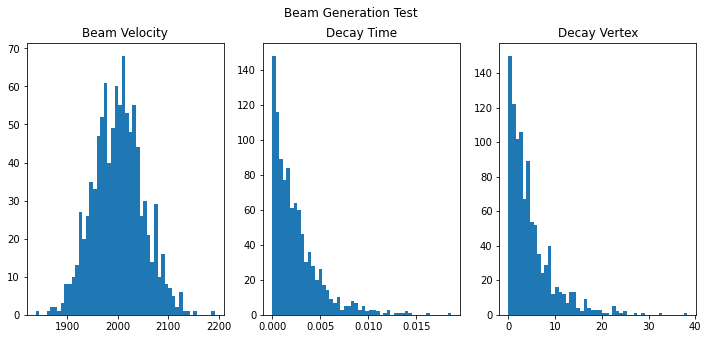

In [4226]:
# test code

test = BeamGeneration(NUM_PARTICLES, MU_VELOCITY, SIGMA_VELOCITY, TAU_MEAN)
test.plot_generation()


## Part 2 - Daughter Particle

Now simulate the direction of the decay product, which should be _isotropic_ in the rest frame of the beam particle. This is the same as generating points on the surface of a unit sphere, with uniform probability over the solid angle $d\Omega$. This can be achieved in spherical coordinates, by generating the two angles, $\phi$ and $\theta$.  These should not have uniform distributions, since the area element is given by :

$${\rm d}\Omega = \sin(\theta) {\rm d}\phi {\rm d}\theta$$

To obtain uniform probability over the sphere, you should generate $\phi$ with a uniform distribution between $0$ and $2\pi$, and $\theta$ with a distribution proportional to $\sin \theta$.

Note that the velocity of the daughter particle is not required in the base experiment, since we will assume the daughter follows a straight line track.  The direction vector we are producing here is equivalent to a unit vector in the direction of the daughter momentum, ie. $\frac{p_{dtr}}{|p_{dtr}|}$.

In the cell below, write functions which simulate the direction of the daughter particle in the rest frame of the beam particle, and the lab frame.

In [4227]:
# decay simulation functions



class BeamDecay(BeamGeneration):

    def __init__(self, NUM_PARTICLES, MU_VELOCITY, SIGMA_VELOCITY, TAU_MEAN, DAUGHTER_SPEED):
        super().__init__(NUM_PARTICLES, MU_VELOCITY, SIGMA_VELOCITY, TAU_MEAN)
        self.d_speed = DAUGHTER_SPEED
        
    def decay_direction_inertial(self):
        
        # Generate dierction angles, only +ve z as tracking stations are +ve z. 
        phi = rand.uniform(0, 2*np.pi, self.N)
        costheta = rand.uniform(0, 1, self.N)
        theta = np.arccos(costheta)

        # Transform to cartesian coordinates, makes Lorentz velocity addition easier.
        x_hat = np.sin(theta) * np.cos(phi)
        y_hat = np.sin(theta) * np.sin(phi)
        z_hat = np.cos(theta)

        cartesian = np.dstack((x_hat,y_hat,z_hat))

        return cartesian
    
    def decay_direction_lab(self):
        
        inert_dir = self.decay_direction_inertial()
        v = self.beam_velocity()
        v = np.expand_dims(v, axis=0)
        c = 3.0e+8

        # Lorentz factors in z-direction.
        beta = v[0,:,2] / c
        gamma = 1 / np.sqrt(1 - beta**2)
        gamma = np.expand_dims(gamma, axis=0)
        gamma = np.expand_dims(gamma, axis=2)

        # Normalise velocities to get direction vectors.
        inert_norm = np.linalg.norm(inert_dir, axis=2)
        inert_norm = np.expand_dims(inert_norm, axis=2)
        r_hat = inert_dir / inert_norm
        u = r_hat * self.d_speed

        # Calculate dot product of frame velocity and particle velocity.
        u_dot_v = (v*u).sum(axis=2)
        u_dot_v = np.expand_dims(u_dot_v, axis=2)

        # Calculate Lorentz velocity vector addition
        lab_vel = (1/(1+(u_dot_v/(c**2)))) * (u/gamma + v + (gamma/((c**2)*(gamma+1)))*u_dot_v*v)

        # Again, normalise.
        lab_norm = np.linalg.norm(lab_vel, axis=2)
        lab_norm = np.expand_dims(lab_norm, axis=2)
        lab_dir = lab_vel / lab_norm

        return lab_dir
    
    def plot_inertial(self):

        fig = plt.figure()
        fig.suptitle("Inertial Frame Decay Direction")
        ax = Axes3D(fig)

        inert_dir = self.decay_direction_inertial()
        ix = inert_dir[0,:,0]
        iy = inert_dir[0,:,1]
        iz = inert_dir[0,:,2]

        ax.scatter(iz, ix, iy, color='red', s=1)
        ax.set_xlim(-1,1)
        plt.show()

    def plot_lab(self):

        fig = plt.figure()
        fig.suptitle("Lab Frame Decay Direction")
        ax = Axes3D(fig)

        lab_dir = self.decay_direction_lab()
        lx = lab_dir[0,:,0]
        ly = lab_dir[0,:,1]
        lz = lab_dir[0,:,2]

        ax.scatter(lz, lx, ly, color='red', s=1)
        ax.set_xlim(-1,1)
        plt.show()


As for Part 1, in the next cell, test your functions and verify the desired distributions are produced.

/var/folders/wf/bt8zjd5j6nzczzxt98q4d86w0000gn/T/ipykernel_80222/3909776932.py:64: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


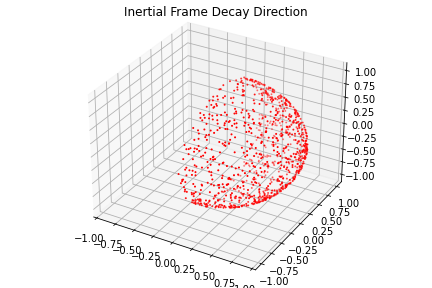

/var/folders/wf/bt8zjd5j6nzczzxt98q4d86w0000gn/T/ipykernel_80222/3909776932.py:79: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


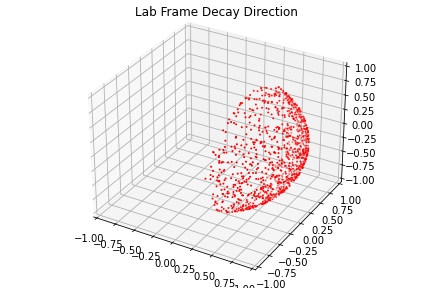

In [4228]:
# test code
%matplotlib widget

plot = BeamDecay(NUM_PARTICLES, MU_VELOCITY, SIGMA_VELOCITY, TAU_MEAN, DAUGHTER_SPEED)

plot.plot_inertial()
plot.plot_lab()

## Part 3 - Propagation to Tracking Stations

The next step is to propagate the daughter particle to the tracking detectors. First, it is convenient to represent the track using a set of parameters. Here, the track is a straight line, which can be represented by 5 parameters :
  * $m_x = \frac{dx}{dz}$ - gradient in the $x$ direction
  * $m_y = \frac{dy}{dz}$ - gradient in the $y$ direction
  * $c_x$ - $x$-intercept at z=0
  * $c_y$ - $y$-intercept at z=0
  * $d$ - track direction (+1 for $+z$ direction, -1 for $-z$ direction)

In the cell below, write a function which calculates the track parameters from the decay vertex and daughter direction in the lab frame.

Then write another function which takes the track parameters, and computes the intercepts of the track with the tracking stations.  The function should accept a list of $z$ coordinates (one for each tracking station) and return the position $r_{hit}$ of the hit at each station.

Note that random numbers are not required for these functions.

In [4229]:
# tracking functions

class DaughterPropagation(BeamDecay):

    def __init__(self, NUM_PARTICLES, MU_VELOCITY, SIGMA_VELOCITY, TAU_MEAN, DAUGHTER_SPEED, STATIONS):
        super().__init__(NUM_PARTICLES, MU_VELOCITY, SIGMA_VELOCITY, TAU_MEAN, DAUGHTER_SPEED)
        self.stations = STATIONS

    def track_parameters(self):

        vertex = self.decay_vertex()
        direction = self.decay_direction_lab()

        # Adjust injection distance so that all decays occur before x-y intercepts.
        inject_to_z0 = np.full((self.N),50)
        decay_to_z0 = inject_to_z0 - vertex[:,2]

        # Calculate dx/dz and dy/dz gradients
        grad_x = direction[0,:,0] / direction[0,:,2]
        grad_y = direction[0,:,1] / direction[0,:,2]

        # Calculate x-y coords of decay product at z=0
        intercept_x = decay_to_z0 * grad_x
        intercept_y = decay_to_z0 * grad_y
        
        parameters = grad_x, grad_y, intercept_x, intercept_y
        return parameters

    def station_hits(self):

        parameters = self.track_parameters()

        gradient = np.array([parameters[0], parameters[1]])
        intercept = np.array([parameters[2], parameters[3]])
        
        # Calculate hit station coordinates.
        hit = [[],[],[],[]]
        for i in range(len(self.stations)):
            hit[i] = intercept + (self.stations[i] * gradient)

        hit_coords = np.transpose(hit,(0,2,1))
        return hit_coords

    def plot_hits(self):

        hit_data = self.station_hits()

        max = math.ceil(np.amax(abs(hit_data[3,:,:])))
        fig = plt.figure()
        fig.suptitle("Tracking Station Hits")
        
        ax = Axes3D(fig, rect=(-0.5,-0.5,2,2))
        ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1, 0.4, 0.4, 1]))
        
        ax.scatter(hit_data[0,:,0], hit_data[0,:,1], zs=self.stations[0], zdir='x', s=1, c='red')
        ax.scatter(hit_data[1,:,0], hit_data[1,:,1], zs=self.stations[1], zdir='x', s=1, c='orangered')
        ax.scatter(hit_data[2,:,0], hit_data[2,:,1], zs=self.stations[2], zdir='x', s=1, c='orange')
        ax.scatter(hit_data[3,:,0], hit_data[3,:,1], zs=self.stations[3], zdir='x', s=1, c='gold')
                
        station_delta = (self.stations[1] - self.stations[0])/2
        ax.set_xlim(self.stations[0]-station_delta, self.stations[3]+station_delta)
        ax.set_ylim(-max, +max)
        ax.set_zlim(-max, +max)
        
        plt.show()


In the next cell, test your track propagation functions. (A qualitative assessment is acceptable here).

/var/folders/wf/bt8zjd5j6nzczzxt98q4d86w0000gn/T/ipykernel_80222/2335739129.py:52: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig, rect=(-0.5,-0.5,2,2))


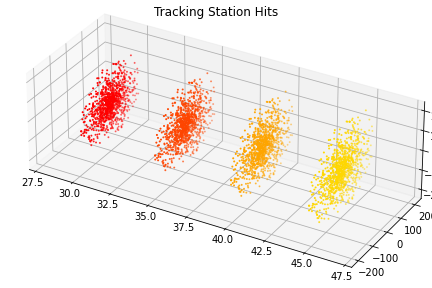

In [4230]:
# test code

tracking_stations = DaughterPropagation(NUM_PARTICLES, MU_VELOCITY, SIGMA_VELOCITY, TAU_MEAN, DAUGHTER_SPEED, STATIONS)

tracking_stations.plot_hits()

## Part 4 - Hit Smearing

The tracking detectors are not perfect, and will measure position with some resolution.  This can be simulated by adding an offset to the true hit position, where the $x$ ($y$) offset is drawn from a normal distribution with a mean of zero and standard deviation $\sigma_{x}$ ($\sigma_{y}$), equal to the resolution of the detector in the $x$ ($y$) direction.  This process is known as smearing.

You should write a function which takes the true hit positions and smears them according to the detector resolution, to produce the reconstructed (or measure) hit positions.

In [4231]:
# smearing function

class HitSmearing(DaughterPropagation):

    def __init__(self, NUM_PARTICLES, MU_VELOCITY, SIGMA_VELOCITY, TAU_MEAN, DAUGHTER_SPEED, STATIONS, DETECTOR_RESOLUTION):
        super().__init__(NUM_PARTICLES, MU_VELOCITY, SIGMA_VELOCITY, TAU_MEAN, DAUGHTER_SPEED, STATIONS)
        self.resolution = DETECTOR_RESOLUTION

    def position_smear(self):

        hit_res = self.resolution

        smear_x = [[],[],[],[]]
        smear_y = [[],[],[],[]]
        for i in range(len(self.stations)):
            smear_x[i] = rand.normal(0, hit_res, self.N)
            smear_y[i] = rand.normal(0, hit_res, self.N)

        smear = [smear_x, smear_y]
        smear = np.transpose(smear,(1,2,0))

        return smear
        
    def measured_hits(self):

        true_hits = self.station_hits()
        smear = self.position_smear()
        #print(np.shape(true_hits))
        #print(np.shape(smear))

        hit = true_hits + smear
        return hit

    def smear_distribution_plot(self):

        true_hits = self.station_hits()
        smeared_hits = self.measured_hits()

        max = math.ceil(np.amax(abs(true_hits[3,:,:])))

        fig, axs = plt.subplots(1, 2, figsize=(11,5))
        fig.suptitle("Hit Comparison (Station 1)")
        axs[0].title.set_text('True')
        axs[1].title.set_text('Measured')
        
        axs[0].set_ylim(-max, +max)
        axs[1].set_xlim(-max, +max)
        
        axs[0].hist2d(true_hits[0,:,0], true_hits[0,:,1], bins=70)
        axs[1].hist2d(smeared_hits[0,:,0], smeared_hits[0,:,1], bins=70)


Again, you should test your code to verify that the desire distributions are indeed produced.

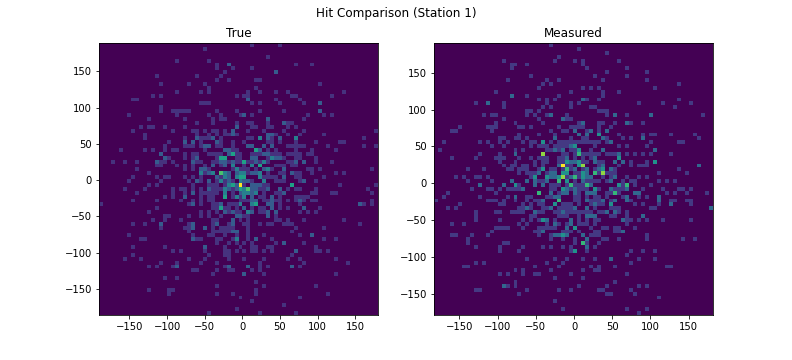

In [4232]:
# test code

hit_smear = HitSmearing(NUM_PARTICLES, MU_VELOCITY, SIGMA_VELOCITY, TAU_MEAN, DAUGHTER_SPEED, STATIONS, DETECTOR_RESOLUTION)

hit_smear.smear_distribution_plot()

## Part 5 - Track Reconstruction

In the real experiment, one would use the measured hits in tracking stations to "reconstruct" the track of the decay product.  You should perform the same process using the smeared hit positions. 

The location of the hits at the $i$-th tracking station can be written in terms of the track parameters $(m_x, m_y, c_x, c_y)$ and the $z$ position of the tracking station :

$$
\begin{pmatrix}
m_x \\
m_y
\end{pmatrix}
z_i
+
\begin{pmatrix}
c_x \\
c_y
\end{pmatrix}
=
\begin{pmatrix}
x_i \\
y_i
\end{pmatrix}
$$

For $N$ tracking stations, we have a set of $N$ such equations.  We can write these equations as a matrix equation  :
$$M j_{trk} = x_{hits}$$

Where $x_{hits}$ is vector containing all the measured hit coordinates, $j_{trk}$ is the track parameters, and $M$ is a matrix which depends on the tracking station positions.  For example, with 3 tracking stations, we have :

$$
\begin{pmatrix}
z_0 & 0   & 1 & 0 \\
0   & z_0 & 0 & 1 \\
z_1 & 0   & 1 & 0 \\ 
0   & z_1 & 0 & 1 \\
z_2 & 0   & 1 & 0 \\
0   & z_2 & 0 & 1
\end{pmatrix}
\begin{pmatrix}
m_x \\
m_y \\
c_x \\
c_y
\end{pmatrix}
=
\begin{pmatrix}
x_0 \\
y_0 \\
x_1 \\
y_1 \\
x_2 \\
y_2
\end{pmatrix}
$$

The track parameters can be obtained by solving the matrix equation above.  When choosing an algorithm to solve the equation, note that there is almost certainly not an exact solution, due to the smearing of hit positions.  You should use an algorithm which will find the _closest_ solution.

In the cell below, write functions to first construct the matrix equation, and then to solve it.

In [4233]:
# track reconstruction functions

class TrackReconstruction(HitSmearing):

    def __init__(self, NUM_PARTICLES, MU_VELOCITY, SIGMA_VELOCITY, TAU_MEAN, DAUGHTER_SPEED, STATIONS, DETECTOR_RESOLUTION):
        super().__init__(NUM_PARTICLES, MU_VELOCITY, SIGMA_VELOCITY, TAU_MEAN, DAUGHTER_SPEED, STATIONS, DETECTOR_RESOLUTION)

    def matrix(self):
        
        sub_matrix = [[],[],[],[]]
        for i in range(len(self.stations)):
            sub_matrix[i] = np.array([
                [self.stations[i], 0, 1, 0],
                [0, self.stations[i], 0, 1]])

        matrix = np.reshape(sub_matrix,(-1, 4))
        return matrix

    def solve_matrix(self):

        matrix = self.matrix()
        hits = self.measured_hits()
        hits = np.transpose(hits, (1,0,2))
        hits = np.reshape(hits, (self.N,-1), 'A')
        hits = np.transpose(hits)
       
        cs = linalg.lstsq(matrix, hits)
        
        return cs
        
        


In the cell below, test your code

In [4234]:
# test code

reconstruct = TrackReconstruction(NUM_PARTICLES, MU_VELOCITY, SIGMA_VELOCITY, TAU_MEAN, DAUGHTER_SPEED, STATIONS, DETECTOR_RESOLUTION)

reconstruct.solve_matrix()

(array([[-1.00759789e+00, -3.73466996e-01,  2.18772389e-01, ...,
          3.62976804e-01,  6.24135689e-01, -2.12249843e-01],
        [ 4.58953169e-02,  1.73258504e-01,  1.62063109e+00, ...,
          1.19173277e-01,  8.99105402e-01,  4.48329538e-01],
        [-4.32833254e+01, -1.55995590e+01,  1.09016910e+01, ...,
          1.72874411e+01,  2.64251468e+01, -9.96480153e+00],
        [ 1.91135663e+00,  7.22701707e+00,  8.03797418e+01, ...,
          5.65682233e+00,  3.79395791e+01,  2.10172997e+01]]),
 array([1.52027869e-04, 4.49629934e-04, 2.80433291e-04, 3.16528261e-04,
        3.82090021e-04, 1.56025470e-04, 5.53987411e-04, 1.76829675e-04,
        3.36151807e-04, 8.73004530e-04, 7.95788745e-05, 3.32048169e-04,
        7.09992176e-04, 3.05557101e-05, 2.90152923e-04, 5.54594540e-04,
        4.19778021e-04, 2.95451916e-04, 1.11473531e-03, 1.64122184e-04,
        3.36398392e-04, 5.38476017e-04, 1.70689679e-04, 2.94093818e-04,
        5.08821324e-04, 1.81552542e-04, 3.59846889e-04, 9.9770

## Part 6 - Vertex Reconstruction

The reconstructed track parameters can be used to estimate the orginal decay position. In the absence of mis-measurement, the $z$ position of the decay can be found from the intercept of the track and the $z$-axis. However, due to the finite detector resolution, the reconstructed track may not exactly intercept the $z$-axis.  Instead, you can use the point where the track is closest, in the $(x-y)$ plane, to the $z$-axis.

The distance from the track to the z-axis can be written :
$$r = \sqrt{x^2 + y^2} = \sqrt{(m_x z + c_x)^2 + (m_y z + c_y)^2}$$

This is a quadratic, $r^2 = a z^2 + b z + c$, where $a = m_x^2 +m_y^2$, $b = 2 (m_x c_x + m_y c_y)$ and $c = c_x^2 + c_y^2$.

By converting to quadratic standard form, we can obtain the value of $z$ where $r^2$ is a minimum :
$$z_{vtx} = - \frac{(m_x c_x + m_y c_y)}{m_x^2 +m_y^2}$$

In the cell below, write a function which uses this formula to calculate the vertex position from the reconstructed track parameters.

In [4235]:
# vertex reconstruction functions

class VertexReconstruction(TrackReconstruction):

    def __init__(self, NUM_PARTICLES, MU_VELOCITY, SIGMA_VELOCITY, TAU_MEAN, DAUGHTER_SPEED, STATIONS, DETECTOR_RESOLUTION):
        super().__init__(NUM_PARTICLES, MU_VELOCITY, SIGMA_VELOCITY, TAU_MEAN, DAUGHTER_SPEED, STATIONS, DETECTOR_RESOLUTION)

    def reconstruct_vertex(self):

        cs = self.solve_matrix()
        parameters = cs[0]

        p = np.transpose(parameters)

        z = -(p[:,0]*p[:,2] + p[:,1]*p[:,3]) / (p[:,0]**2 + p[:,1]**2)

        inj_to_dec = z + 50
        
        return inj_to_dec

    def vertex_plot(self):
        
        true_vertex = self.decay_vertex()
        reconstructed_vertex = self.reconstruct_vertex()

        print("Reconstructed Decay Vertex Mean: "+str(np.mean(reconstructed_vertex)))
        print("True Decay Vertex Mean: "+str(np.mean(true_vertex[:,2])))

        fig, axs = plt.subplots(1, 2, figsize=(11,5))
        fig.suptitle("Decay Vertex Comparison")
        axs[0].title.set_text('True')
        axs[1].title.set_text('Reconstructed')
        
        axs[0].hist(true_vertex[:,2], bins=50)
        axs[1].hist(reconstructed_vertex, bins=50)


In the next cell, verify this function operates as desired.

Reconstructed Decay Vertex Mean: 5.367720099847293
True Decay Vertex Mean: 5.041868581930179


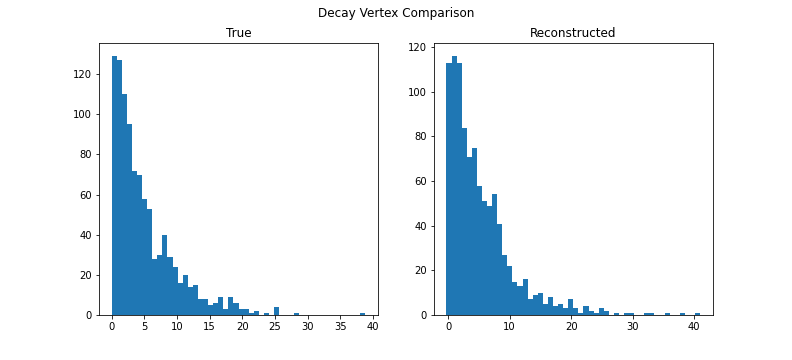

In [4236]:
# test code

vertices = VertexReconstruction(NUM_PARTICLES, MU_VELOCITY, SIGMA_VELOCITY, TAU_MEAN, DAUGHTER_SPEED, STATIONS, DETECTOR_RESOLUTION)

vertices.vertex_plot()

## Part 7 - Full Experiment Simulation

Now you are ready to simulate the full experiment.  You should produce a large sample of events.  For each event, generate a beam particle, a daughter particle, the true and smeared hits, the reconstructed track and the reconstructed vertex.

Given a sample of events, it is possible to compute distributions of various quantities that will inform the design of the experiment.  You should present at least the following :
   * Number of tracking station hits
   * Difference between true and reconstructed decay vertex $z$-coordinate
   * Reconstructed decay vertex $z$-coordinate - which can be used to estimate the measured particle lifetime.

It can also be interesting to explore how these distributions change for different assumptions about the experimental setup, ie. the size, position and resolution of the tracking stations, and the true lifetime of X. As a starting point, you should assume the experiment aims to measure the lifetime of an unstable nucleus undergoing beta decay, with the following parameters :
   * X mean lifetime, $\tau = 2.5 {\rm ms}$
   * Mean X velocity, $\mu_v = 2000 {\rm ms}^{-1}$
   * Std dev X velocity, $\sigma_v = 50 {\rm ms}^{-1}$
   * Tracking station positions, $z_{stn} = 30, 35, 40, 45 {\rm m}$
   * Tracking hit resolution, $\sigma_{rx, ry} = 0.01 {\rm m}$

In [4237]:
# full experiment simulation 
beam = BeamGeneration(NUM_PARTICLES, MU_VELOCITY, SIGMA_VELOCITY, TAU_MEAN)
speed = beam.beam_velocity()
distance = vertices.reconstruct_vertex()



In [4238]:
# analysis code

## Part 8 - Discussion

In the markdown cell below, describe how your code solves the problem set. State any equations used in the solution and how they were obtained. Include your reasons for any libraries you used, as well as any particular programming techniques. Explain your choice of any test cases. Finally, state any salient features of the results you obtained, and any conclusions. You are not expected to write more than 600-700 words, and you don't need to repeat information already given in the assignment.

The program above utilises a number of Monte Carlo systems to simulate the decay experiment. I employed a multilevel inheritance approach given the iterative nature of the experiment; all calculations lead into the subsequent ones, so the class system should reflect that. Should the program not have been relatively small, this approach may have become untenable with many parameters and the possibility of inheritance confusion. As it stands, this method is appropriate.

The inertial to lab frame velocity calculations were derived from Lorentz transformation equations; spherical to cartesian coordinates were calculated to make this more straightforward and to aid in the subsequent 3D and 2D density plots. Dimensional manipulation proved to be the most prevalent aspect of code. Due to the many different sorts of calculations, np.shape() was used extensively to test array sizes and then reshape arrays for purpose. This was especially important for the matrix calculations as the data had to be reformed and zipped correctly. 

The mpl_toolkits.mplot3d package was of great importance for both presenting data and testing the 3d distribution of direction vectors at the decay vertex, particularly for ensuring uniform spherical distribution in the inertial frame. Once transformed to the lab frame, the decay products can be seen to have an increased z velocity. At this point I went back and changed the distribution in the inertial frame to be hemispherical. This was because we are interested in +z velocities, as the tracking stations are at +z coords. In order to save computing power and get data for the most amount of events, this was the natural solution. It also superseded the necessity to remove -z velocity events from calculations involving the track parameters later on.

To solve the matrix equation for track parameter reconstruction, the script.linalg library was utilised. The lstsq() function computes a least squares solution to the matrix equation. It does this by computing a vector such that the norm |b-Mx| is minimised. The routine uses the ‘gelsd’ lapack-driver. 
 
The problem is solved in three steps:
 (1) Reduce the coefficient matrix M to bidiagonal form with
     Householder transformations, reducing the original problem
     into a "bidiagonal least squares problem" (BLS)
 (2) Solve the BLS using a divide and conquer approach.
 (3) Apply back all the Householder transformations to solve
     the original least squares problem.

 The divide and conquer algorithm makes very mild assumptions about floating point arithmetic.